In [1]:
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
!bash tumor-segmentation-unet/download_data.sh
!python tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/

^C
  Using cached https://files.pythonhosted.org/packages/79/e0/5dd25068a231cd817265529368aca2f918049b290dcb2fd9b24ce136adf4/hdf5storage-0.1.15-py2.py3-none-any.whl
^C
'bash'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
python: can't open file 'tumor-segmentation-unet/mat_to_numpy.py': [Errno 2] No such file or directory
Cloning into 'brain-tumor-segmentation-unet'...


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.clip( (np.load('brain_tumor_dataset/images.npy')/12728),0,1)
masks = np.load('brain_tumor_dataset/masks.npy')*1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [2]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)  

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


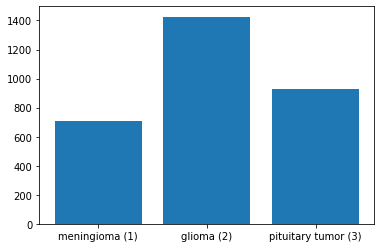

In [3]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

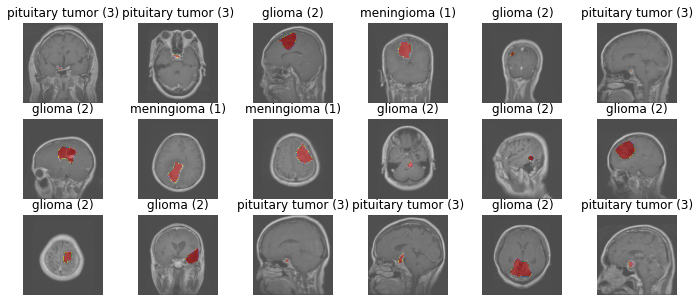

In [4]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

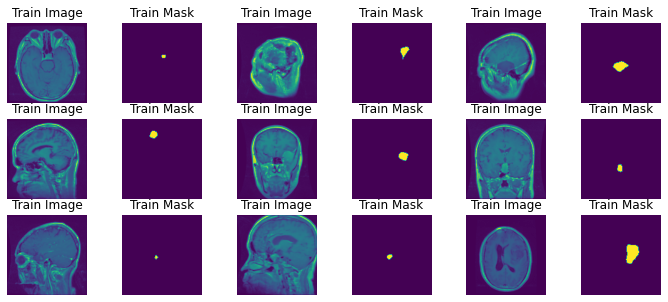

In [5]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1)) 
  plt.title("Train Mask")
  plt.axis('off')

In [6]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

### Augmentation

In [8]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

### Defining Dice Loss
Dice = 2|A∩B|/|A|+|B|

In [7]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    y_true_f = tf.cast(y_true_f,tf.float32)
    y_pred_f = tf.cast(y_pred_f,tf.float32)

    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  

inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
contraction_1_1 (Conv2D)        (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
contraction_1_2 (Conv2D)        (None, 128, 128, 64) 36928       contraction_1_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           contraction_1_2[0][0]            
______________________________________________________________________________________________

### Defining IOU metric and compile Model

In [9]:
def get_iou_vector(A, B):
    t = A
    p = B
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.py_function(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(lr=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy',iou_metric])


In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [15]:


model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)

hist = unet.fit(
                    X,
                    Y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_v,Y_v),
                    verbose=1,
                    callbacks= callback_list
        )
        


Epoch 1/100
154/154 [==============================] - 39s 245ms/step - loss: 1.0735 - accuracy: 0.9843 - iou_metric: 0.0410 - val_loss: 1.0017 - val_accuracy: 0.9901 - val_iou_metric: 0.0521

Epoch 00001: val_loss improved from inf to 1.00168, saving model to model_best_checkpoint.h5
Epoch 2/100
154/154 [==============================] - 36s 232ms/step - loss: 0.6672 - accuracy: 0.9877 - iou_metric: 0.2598 - val_loss: 0.5588 - val_accuracy: 0.9919 - val_iou_metric: 0.3526

Epoch 00002: val_loss improved from 1.00168 to 0.55878, saving model to model_best_checkpoint.h5
Epoch 3/100
154/154 [==============================] - 36s 234ms/step - loss: 0.4850 - accuracy: 0.9909 - iou_metric: 0.4082 - val_loss: 0.4516 - val_accuracy: 0.9922 - val_iou_metric: 0.4395

Epoch 00003: val_loss improved from 0.55878 to 0.45159, saving model to model_best_checkpoint.h5
Epoch 4/100
154/154 [==============================] - 36s 234ms/step - loss: 0.4277 - accuracy: 0.9919 - iou_metric: 0.4568 - val_los

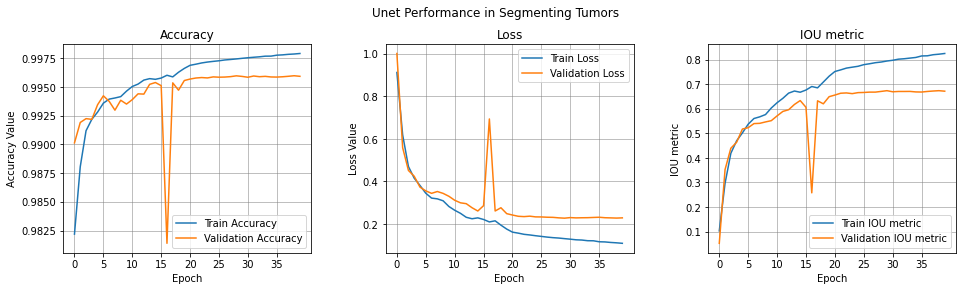

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [11]:
unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

In [12]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
  
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

Text(0.5, 1.0, 'Threshold vs IoU (0.7171717171717172, 0.7804145975933967)')

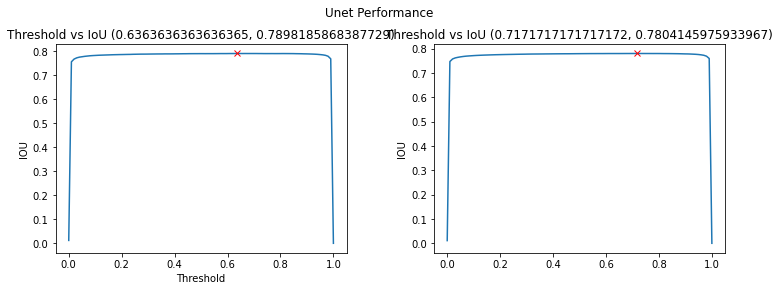

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

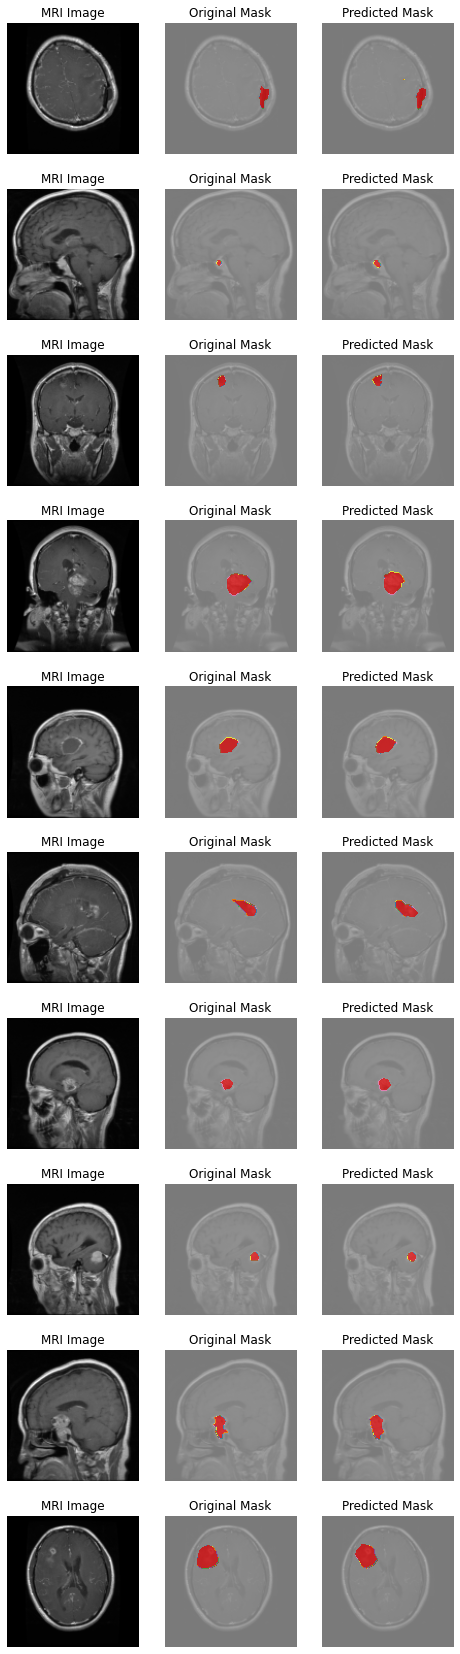

In [16]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.8, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.8, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

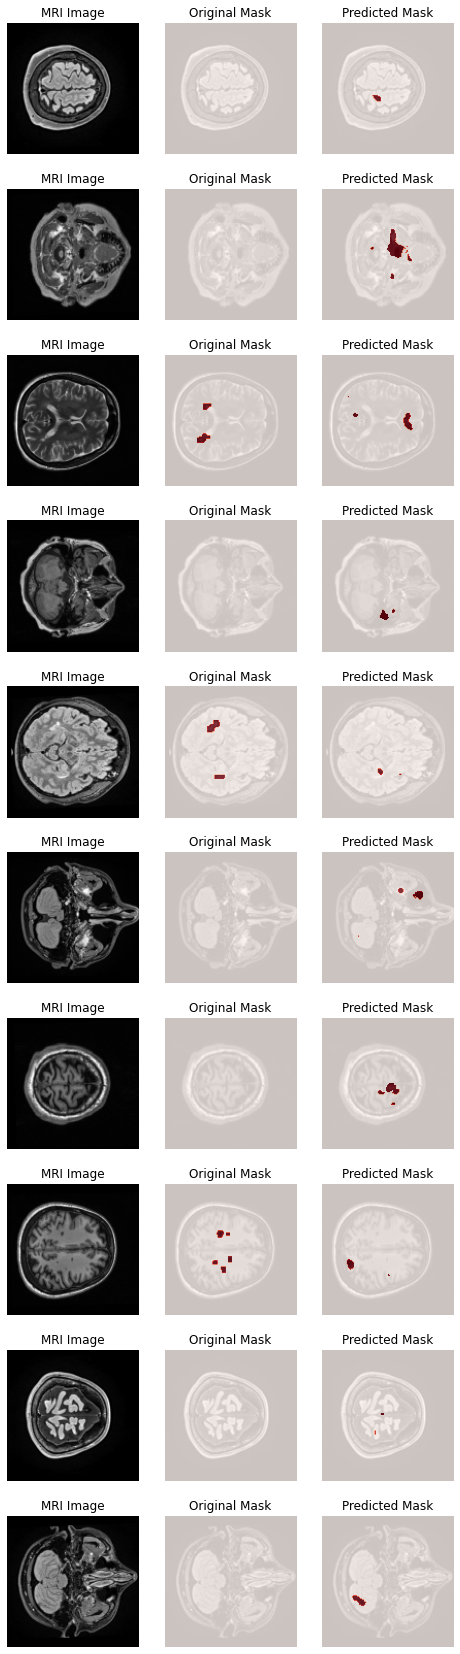

In [17]:
integer_to_class = { '1': 'no_lesion (1)', '2': 'lesion (2)' }

NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
t1w_images = np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255
t2f_images = np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255
t2w_images = np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255
masks = np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255

HAS_RESIZING = True

# resizing
img_size_ori = (260,320)
img_size_target = (128,128)

t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

from skimage.transform import resize

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target[0], img_size_target[1]), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori[0], img_size_ori[1]), mode='constant', preserve_range=True)

# if HAS_RESIZING:
t1w_images = np.array([ downsample(image) for image in t1w_images ])
t2f_images = np.array([ downsample(image) for image in t2f_images ])
t2w_images = np.array([ downsample(image) for image in t2w_images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

image_datasets = np.concatenate((t1w_images,t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels,labels),axis =0)


THRESHOLD = 0.2
predicted_mask = (unet.predict(image_datasets)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10

temp = np.ones_like( mask_datasets[0] )
for idx in np.random.randint(0,high=image_datasets.shape[0],size=10):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(image_datasets[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(image_datasets[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(mask_datasets[idx],axis=-1), alpha=0.8, cmap='Reds' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(image_datasets[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(predicted_mask[idx],axis=-1),  alpha=0.8, cmap='Reds' )
    plt.title("Predicted Mask");plt.axis('off')